In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import hdbscan
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
images_df = pd.read_csv('../../../processed_galaxy_data/processed_galaxy_data/flattened_normalized_images.csv', header=None)
labels_df = pd.read_csv('../../../processed_galaxy_data/processed_galaxy_data/labels_mappings_filtered.csv')

In [8]:
data_for_clustering = images_df.values
labels = labels_df['shape_label'].values

In [9]:
# Stratified sampling
_, sample_data, _, sample_labels = train_test_split(data_for_clustering, labels, stratify=labels, train_size=2396, random_state=50)

In [10]:
# Standardize data
scaler = StandardScaler()
sample_data_scaled = scaler.fit_transform(sample_data)

### PCA

In [11]:
pca = PCA(n_components=35)
data_reduced = pca.fit_transform(sample_data_scaled)

### K-Means + UMAP

In [12]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=100, verbose=1)
kmeans_labels = kmeans.fit_predict(data_reduced)
print(f"K-Means Silhouette Score: {silhouette_score(data_reduced, kmeans_labels)}")

Initialization complete
Iteration 0, inertia 411658993.30006164.
Iteration 1, inertia 346892721.09957296.
Iteration 2, inertia 339284696.44227517.
Iteration 3, inertia 334312328.7613667.
Iteration 4, inertia 330571946.0865374.
Iteration 5, inertia 327905164.2898457.
Iteration 6, inertia 326190465.57944953.
Iteration 7, inertia 325186126.63485414.
Iteration 8, inertia 324627403.3898976.
Iteration 9, inertia 324297808.5308327.
Iteration 10, inertia 324069549.18300426.
Iteration 11, inertia 323888702.82174265.
Iteration 12, inertia 323732500.1828275.
Iteration 13, inertia 323593364.58177376.
Iteration 14, inertia 323458545.44599855.
Iteration 15, inertia 323324720.0007929.
Iteration 16, inertia 323186956.70116675.
Iteration 17, inertia 323058653.2654995.
Iteration 18, inertia 322946079.22279894.
Iteration 19, inertia 322859311.82676226.
Iteration 20, inertia 322794180.7575916.
Iteration 21, inertia 322744965.33188903.
Iteration 22, inertia 322706773.4145816.
Iteration 23, inertia 32267659

In [16]:
umap_reducer_2d = UMAP(n_components=2, random_state=10)
data_2d = umap_reducer_2d.fit_transform(sample_data_scaled)

/Users/Art/opt/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [18]:
def plot_clusters(data_2d, labels, title):
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1], hue=labels, palette="viridis", legend='full', alpha=0.7)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

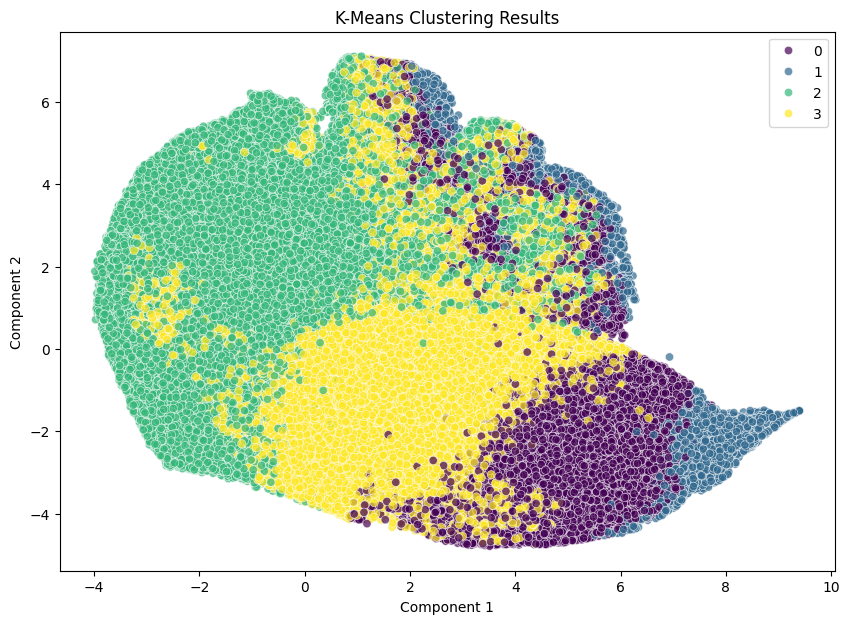

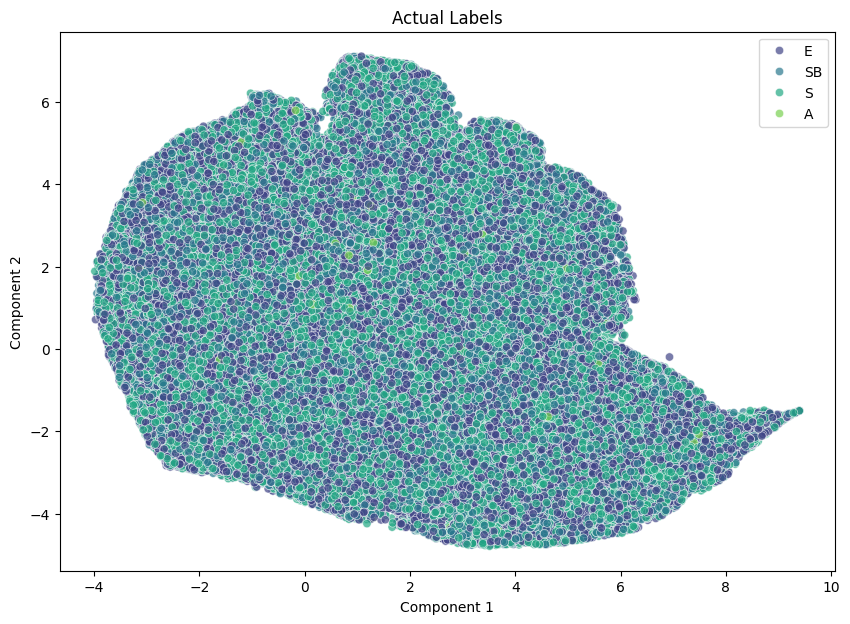

In [19]:
# Plot clustering results
plot_clusters(data_2d, kmeans_labels, 'K-Means Clustering Results')

# Plot actual labels for comparison
plot_clusters(data_2d, sample_labels, 'Actual Labels')

### GMM + UMAP

In [13]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=150, verbose=2)
gmm_labels = gmm.fit_predict(data_reduced)
print(f"GMM Silhouette Score: {silhouette_score(data_reduced, gmm_labels)}")

Initialization 0
  Iteration 10	 time lapse 3.82884s	 ll change 0.03150
  Iteration 20	 time lapse 3.16945s	 ll change 0.05453
  Iteration 30	 time lapse 3.20299s	 ll change 0.00337
Initialization converged: True	 time lapse 12.03814s	 ll -89.55528
GMM Silhouette Score: -0.00045258374382898734


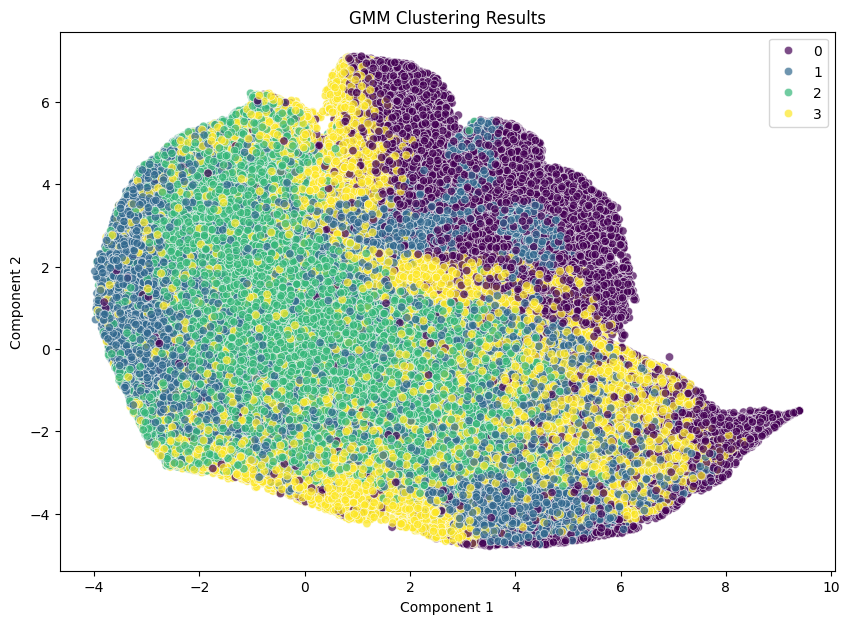

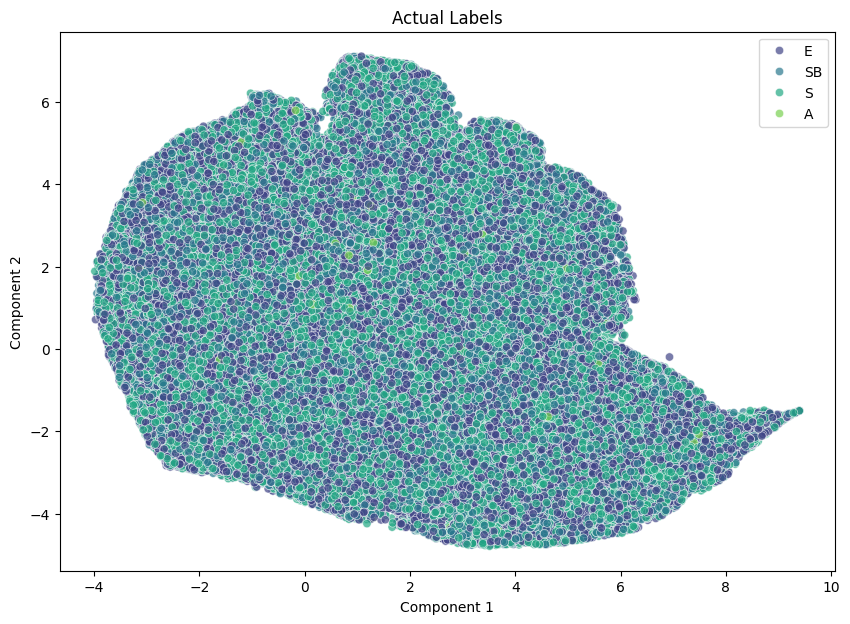

In [20]:
plot_clusters(data_2d, gmm_labels, 'GMM Clustering Results')

plot_clusters(data_2d, sample_labels, 'Actual Labels')

### HDBSCAN + UMAP

In [21]:
hdbscan = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
hdbscan_labels = hdbscan.fit_predict(data_reduced)
print(f"HDBSCAN Silhouette Score: {silhouette_score(data_reduced, hdbscan_labels)}")

HDBSCAN Silhouette Score: 0.33173875308805556


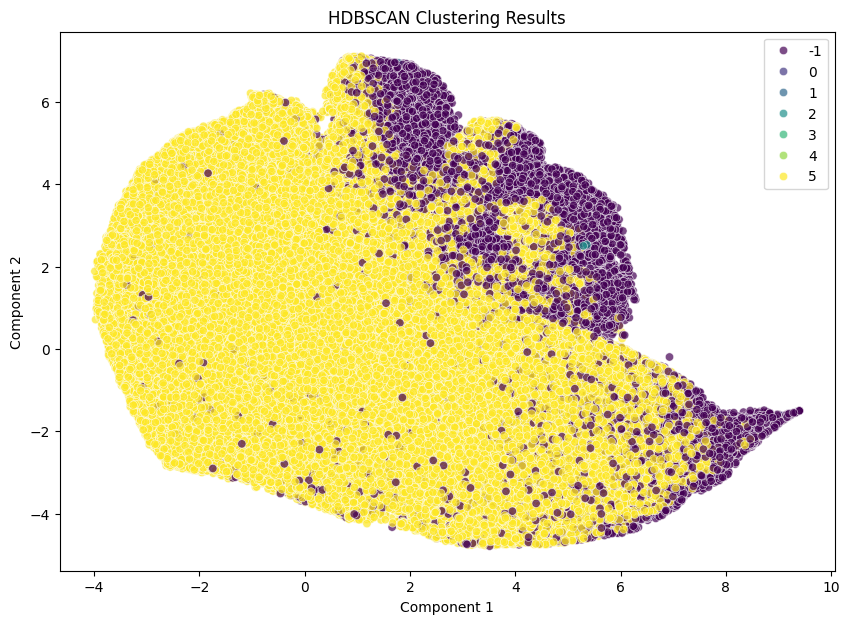

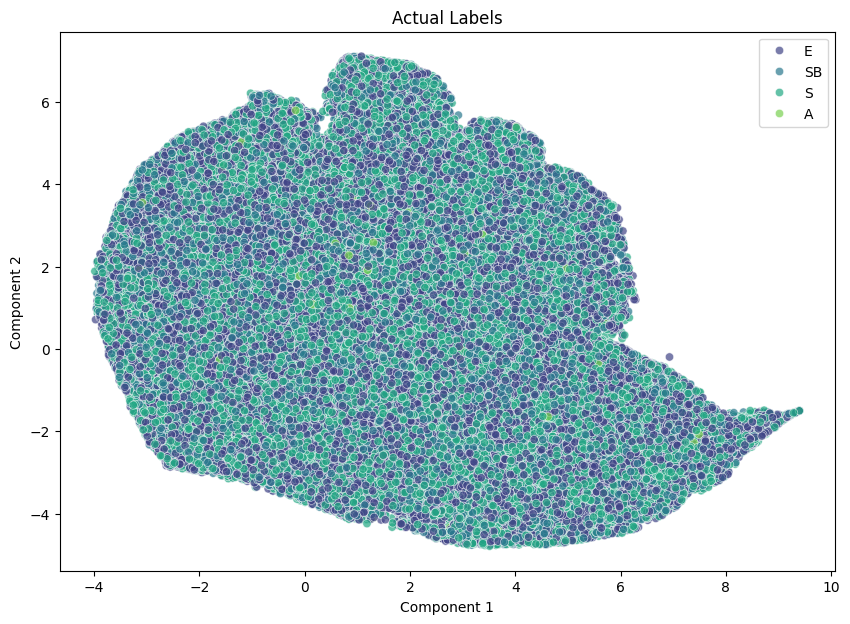

In [22]:
plot_clusters(data_2d, hdbscan_labels, 'HDBSCAN Clustering Results')

plot_clusters(data_2d, sample_labels, 'Actual Labels')

#### Best Run

In [ ]:
hdbscan = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
hdbscan_labels = hdbscan.fit_predict(data_reduced)
print(f"HDBSCAN Silhouette Score: {silhouette_score(data_reduced, hdbscan_labels)}")

HDBSCAN Silhouette Score: 0.33200252120142


In [ ]:
ari_score_hdbscan = adjusted_rand_score(sample_labels, hdbscan_labels)
print(f"HDBSCAN Adjusted Rand Index: {ari_score_hdbscan}")

HDBSCAN Adjusted Rand Index: 0.0003757648013197568


### Hierarchical Clustering

The kernel dies for hierarchical, even when reducing further to 240 samples in an attempt to lessen computational load.

### Comments

The 1% subset of the data appears to be representative, as it has essentially the same shape of the UMAP reduction in the PCA_UMAP_DBSCAN notebook. Moreover, we can see from both the fairly low silhouette scores on the PCA-reduced data (the highest was HDBSCAN's silhouette score of 0.33200252120142, however its ARI was just 0.0003757648013197568, so it doesn't match well with the actual labels) and from the UMAP-reduced visualization of the actual labels, in addition to the results of the other notebooks such as PCA_UMAP_DBSCAN, that the data does not appear to be well seperable by cluster. Lastly, I outline other potential reasons for not-so-good clustering in the PCA_UMAP_DBSCAN notebook.